# Orders

Gran parte de nuestra tarea es crear "Features", variables en los datos que representan un aspecto del fen√≥meno que estudiamos y nos ayudan a explicarlo.

**Ejercicio**

Vamos a investigar la relaci√≥n entre orders y el score.

La idea es crear un dataframe con las siguientes features:

| feature_name 	                | type 	| description 	                                                                                                                                         |
|:------------------------------|:---:	|:------------------------------------------------------------------------------------------------------------------------------------------------------|
| `order_id` 	                  | str 	| the id of the order 	                                                                                                                                 |
| `tiempo_de_espera` 	          | float 	| numero de d√≠as entre order_date y delivered_date 	                                                                                                    |
| `tiempo_de_espera_previsto` 	 | float 	| numero de d√≠as entre order_date y estimated_delivery_date 	                                                                                           |
| `real_vas_esperado` 	         | float 	| si la fecha de entrega real es posterior a la fecha de entrega estimada, devuelve el n√∫mero de d√≠as entre las dos fechas; de lo contrario, devuelve 0 |
| `order_status` 	              | str 	| statusde la orden	                                                                                                                                    |
| `es_cinco_estrellas` 	        | int 	| 1 si tuvo cinco estrellas en la  review, 0 caso contrario 	                                                                                           |
| `es_una_estrella` 	           | int 	| 1 si tuvo una estrella, 0 caso contrario 	                                                                                                            |
| `review_score` 	              | int 	| from 1 to 5 	                                                                                                                                         |
| `numero_de_productos` 	       | int 	| numero de productos que contiene una orden	                                                                                                           |
| `numero_de_vendedores` 	      | int 	| numero de vendedores unicos                                                                                                                           |
| `precio` 	                    | float 	| total del precio pagado por el cliente                                                                                                                |
| `valor_transporte` 	          | float 	| el valor del freight pagado por el cliente 	                                                                                                          |
| `distancia_al_cliente` 	      | float 	| distancia en km entre cliente y vendedor 	                                                                                                  |
  
Queremos filtrar las ordenes no entregadas

## Metodolog√≠a:

Vamos a crear dos notebooks una de testeo y otra para importar nuestro paquete preprocess.orders_data y de ah√≠ ir elavorando los m√©todos.

1er M√©todo: Load_data: Trae el dataset sin nulos de una ubicaci√≥n ya prefijada.

###  Buenas Pracitcas


Las notebooks se pueden hacer muy largas y desordenadas.
- Codifique su l√≥gica para que siempre se pueda ejecutar de arriba a abajo sin fallar (Celda --> Ejecutar todo)
- Nombre sus variables con lo que significa y para que otra persona pueda entenderlo.
- Use nombres como `tmp` o `_` para pasos intermedios si sabe que no va a usarlos mucho tiempo
- Borre su c√≥digo y combine celdas cuando sea relevante para minimizar el tama√±o del Notebook (`Shift-M`)
- Oculte la salida de su celda si ya no necesita verla (haga doble clic en la secci√≥n roja `Out[]:` a la izquierda de su celda).
- Utilice la Structure de pycharm o Juypter lab para organizarse
- Shortcuts
    - `a` para insertar una celda arriba
    - `b` para insertar una celda debajo
    - `dd` para borrar una celda
    - `esc` y `flechas` para moverse entre celdas
    - `Shift-Enter` para ejecutar la celda y mover el foco a la siguiente
    - `Shift + Tab` cuando entre par√©ntesis de m√©todo, p. ¬°`groupby()` para obtener los documentos! Repita varias veces para abrirlo permanentemente

In [124]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [127]:
%run "/content/drive/MyDrive/olist/2orders.ipynb"

In [128]:
data_dict = load_all_data("/content/drive/MyDrive/olist")


# Verificar si los datos se cargaron correctamente
if data_dict is not None:
    print("Datos cargados correctamente.")
    # Para acceder a los DataFrames individualmente:
    # Ej: data_dict['nombre_dataset']
else:
    print("Error al cargar los datos. Por favor, revisa la ruta de la carpeta.")


Datos cargados correctamente.


In [129]:
# Normalizo los nombres de los DataFrames cargados usando la funci√≥n normalize_name
normalized_data_dict = {normalize_name(name): df for name, df in data_dict.items()}

# Verificar si los datos se cargaron correctamente
if normalized_data_dict:
    print("Datos cargados correctamente.")
    # Puedo acceder a los DataFrames individualmente usando sus nombres normalizados
    # Ejemplo: normalized_data_dict['nombre_dataset']
else:
    print("Error al cargar los datos. Por favor, revisa la ruta de la carpeta.")


Datos cargados correctamente.


In [130]:
data_dict.keys()

dict_keys(['order_reviews', 'geolocation', 'customers', 'order_items', 'orders', 'products', 'order_payments', 'sellers', 'product_category_name_translation'])

In [131]:
orders = data_dict['orders'].copy() # buena practica para estar seguro que no modificas tu dataset original

In [132]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [133]:
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

## 1. Crear orders.py

### a) `tiempo_de_espera`
    Armar un dataframe que tenga
           order_id, tiempo_de_espera, tiempo_de_espera_previsto, real_vs_esperado, status_de_la_orden


In [134]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

# Pasos a seguir

> 1. Explora el dataframe `orders`
2. Filtra por `delivered orders`
3. Manipul√° correctamente `datetime` (record√° el examen)
    - Repas√°[`datetime`](https://docs.python.org/3/library/datetime.html)
    - M√©todos para pasar "string" type a "pandas.datetime'  [`pandas.to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)
4. Crea la columna `tiempo_de_espera`
5. Crea la columna  `tiempo_de_espera_previsto`
6. Crea la columna  `real_vs_esperado`
7. Chequea el nuevo dataset
8. Una vez terminado el c√≥digo pasalo a tu librer√≠a `order.py`

Tanto para `tiempo_de_espera` como para `tiempo_de_espera_previsto`, debe restar las fechas/marcas de tiempo relevantes para obtener la diferencia horaria entre los objetos `pandas.datetime`. Luego, puede usar [`datetime.timedelta()`](https://docs.python.org/3/library/datetime.html#timedelta-objects) o [`np.timedelta64()`](https ://numpy.org/doc/stable/reference/arrays.datetime.html#datetime-and-timedelta-arithmetic) para averiguar cu√°ntos d√≠as representa esa resta.


In [135]:
orders.head(2)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00

In [136]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [137]:

orders_delivered = orders.loc[orders['order_status'] == 'delivered']
orders = orders_delivered


In [138]:
orders['order_status'].unique()


array(['delivered'], dtype=object)

In [139]:
orders_delivered.head(2)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00

In [140]:
orders.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [141]:
orders = transformar_columnas_datetime(orders)


Columnas ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'] convertidas a formato de datetime.


### Crear una columna
Es lo mismo utilizar .loc para asignar una columna nueva, que utilizar .assign o simplemente df['columna'] = operaci√≥n

##  Compute just the number of days in each time_delta
import datetime
one_day_delta = datetime.timedelta(days=1) # lleva el time delta a un d√≠a
one_day_delta = np.timedelta64(24, 'h') # tambi√©n se puede hacer de esta manera


* \ se puede usar para ahorrar espacio
orders.loc[:,'tiempo_de_espera'] = \
    (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']) / one_day_delta

(orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.da


# pasarlo a modulo

Crear la funcion tiempo_de_espera e implementarla

to write python code


def tiempo_de_espera(orders, is_delivered=True):
    # filtrar por entregados y crea la varialbe tiempo de espera
    if is_delivered:
        orders = orders.query("order_status=='delivered'").copy()
    # compute wait time
    orders.loc[:, 'tiempo_de_espera'] = \
        (orders['order_delivered_customer_date'] -
         orders['order_purchase_timestamp']) / np.timedelta64(24, 'h')
    return orders

def

In [142]:
%run "/content/drive/MyDrive/olist/2orders.ipynb"
orders = tiempo_de_espera(orders,is_delivered=False)
orders = tiempo_de_espera_previsto(orders)
orders.head()



order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  tiempo_de_espera  tiempo_de_espera_previsto  
0                    2017-10-18          8.436574                  15.544063  
1                    2018-08-13         13.782037                  19.137766  
2                    2018-09-04          9.394213                  26.639711  
3                    2017-12-15         13.208750                  26.188819  
4                    2018-02-26          2.873877                  12.112049

In [143]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
tiempo_de_espera                        float64
tiempo_de_espera_previsto               float64
dtype: object

In [144]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'tiempo_de_espera', 'tiempo_de_espera_previsto'],
      dtype='object')

In [145]:
%run "/content/drive/MyDrive/olist/2orders.ipynb"
calcular_real_vs_esperado(orders)

In [146]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'tiempo_de_espera', 'tiempo_de_espera_previsto', 'real_vs_esperado'],
      dtype='object')

In [147]:
orders

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp   order_approved_at  \
0        delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   
...            ...                      ...                 ...   
99436    delivered      2017-03-09 09:54:05 2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58 2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43 2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30 2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  tiempo_de_espera  \
0                        2017-10-18          8.436574   
1                        2018-08-13         13.782037   
2                        2018-09-04          9.394213   
3                        2017-12-15         13.208750   
4                        2018-02-26          2.873877   
...                             ...               ...   
99436                    2017-03-28          8.218009   
99437                    2018-03-02         22.193727   
99438                    2017-09-27         24.859421   
99439                    2018-02-15         17.086424   
99440                    2018-04-03          7.674306   

       tiempo_de_espera_previsto  real_vs_esperado  
0                      15.544063               0.0  
1                      19.137766               0.0  
2                      26.639711               0.0  
3                      26.188819               0.0  
4                      12.112049               0.0  
...                          ...               ...  
99436                  18.587442               0.0  
99437                  23.459051               0.0  
99438                  30.384225               0.0  
99439                  37.105243               0.0  
99440                  25.126736               0.0  

[96478 rows x 11 columns]

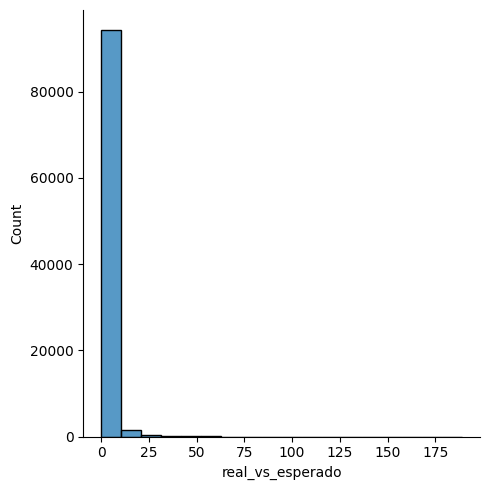

In [148]:
sns.displot(orders['real_vs_esperado'])

In [149]:
punto_a = orders[['order_id', 'tiempo_de_espera', "tiempo_de_espera_previsto", 'order_estimated_delivery_date', 'real_vs_esperado', 'order_status']]

punto_a = punto_a[punto_a['order_status'] == 'delivered']

punto_a.reset_index(drop=True, inplace=True)


punto_a.head()


order_id  tiempo_de_espera  \
0  e481f51cbdc54678b7cc49136f2d6af7          8.436574   
1  53cdb2fc8bc7dce0b6741e2150273451         13.782037   
2  47770eb9100c2d0c44946d9cf07ec65d          9.394213   
3  949d5b44dbf5de918fe9c16f97b45f8a         13.208750   
4  ad21c59c0840e6cb83a9ceb5573f8159          2.873877   

   tiempo_de_espera_previsto order_estimated_delivery_date  real_vs_esperado  \
0                  15.544063                    2017-10-18               0.0   
1                  19.137766                    2018-08-13               0.0   
2                  26.639711                    2018-09-04               0.0   
3                  26.188819                    2017-12-15               0.0   
4                  12.112049                    2018-02-26               0.0   

  order_status  
0    delivered  
1    delivered  
2    delivered  
3    delivered  
4    delivered

### b) `puntaje_de_compra`
     retorna un dataframe con
        order_id, es_cinco_estrellas, es_una_estrella, review_score

recordar del examen `DataFrame.apply()` o tmb se puede usar`Series.map()`


üëâ We load the `reviews` for you

In [150]:
reviews = normalized_data_dict['order_reviews'].copy()

reviews.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parab√©ns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

In [151]:
reviews.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [152]:
%run "/content/drive/MyDrive/olist/2orders.ipynb"
reviews = puntaje_de_compra(reviews)


In [153]:
reviews.head(5)

order_id  es_cinco_estrellas  es_una_estrella  \
0  73fc7af87114b39712e6da79b0a377eb                   0                0   
1  a548910a1c6147796b98fdf73dbeba33                   1                0   
2  f9e4b658b201a9f2ecdecbb34bed034b                   1                0   
3  658677c97b385a9be170737859d3511b                   1                0   
4  8e6bfb81e283fa7e4f11123a3fb894f1                   1                0   

   review_score_original  
0                      4  
1                      5  
2                      5  
3                      5  
4                      5

In [154]:
reviews

order_id  es_cinco_estrellas  es_una_estrella  \
0      73fc7af87114b39712e6da79b0a377eb                   0                0   
1      a548910a1c6147796b98fdf73dbeba33                   1                0   
2      f9e4b658b201a9f2ecdecbb34bed034b                   1                0   
3      658677c97b385a9be170737859d3511b                   1                0   
4      8e6bfb81e283fa7e4f11123a3fb894f1                   1                0   
...                                 ...                 ...              ...   
99219  2a8c23fee101d4d5662fa670396eb8da                   1                0   
99220  22ec9f0669f784db00fa86d035cf8602                   1                0   
99221  55d4004744368f5571d1f590031933e4                   1                0   
99222  7725825d039fc1f0ceb7635e3f7d9206                   0                0   
99223  90531360ecb1eec2a1fbb265a0db0508                   0                1   

       review_score_original  
0                          4  
1                          5  
2                          5  
3                          5  
4                          5  
...                      ...  
99219                      5  
99220                      5  
99221                      5  
99222                      4  
99223                      1  

[99224 rows x 4 columns]

### c) `numero_de_productos`:
     retorna un dataframe con
        order_id, numero_de_productos (numero_de_productos_por_orden)

In [155]:
%run "/content/drive/MyDrive/olist/2orders.ipynb"
data = generar_data(normalized_data_dict["order_items"],normalized_data_dict["products"], "product_id")
data

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value   product_category_name  \
0       2017-09-19 09:45:35   58.90          13.29              cool_stuff   
1       2017-05-03 11:05:13  239.90          19.93                pet_shop   
2       2018-01-18 14:48:30  199.00          17.87        moveis_decoracao   
3       2018-08-15 10:10:18   12.99          12.79              perfumaria   
4       2017-02-13 13:57:51  199.90          18.14      ferramentas_jardim   
...                     ...     ...            ...                     ...   
112645  2018-05-02 04:11:01  299.99          43.41   utilidades_domesticas   
112646  2018-07-20 04:31:48  350.00          36.53  informatica_acessorios   
112647  2017-10-30 17:14:25   99.90          16.95           esporte_lazer   
112648  2017-08-21 00:04:32   55.99           8.72  informatica_acessorios   
112649  2018-06-12 17:10:13   43.00          12.79         cama_mesa_banho   

        product_name_lenght  product_description_lenght  product_photos_qty  \
0                      58.0                       598.0                 4.0   
1                      56.0                       239.0                 2.0   
2                      59.0                       695.0                 2.0   
3                      42.0                       480.0                 1.0   
4                      59.0                       409.0                 1.0   
...                     ...                         ...                 ...   
112645                 43.0                      1002.0                 3.0   
112646                 31.0                       232.0                 1.0   
112647                 43.0                       869.0                 1.0   
112648                 56.0                      1306.0                 1.0   
112649                 47.0                       511.0                 1.0   

        product_weight_g  product_length_cm  product_height_cm  \
0                  650.0               28.0                9.0   
1                30000.0               50.0               30.0   
2                 3050.0               33.0               13.0   
3                  200.0               16.0               10.0   
4                 3750.0               35.0               40.0   
...                  ...                ...                ...   
112645           10150.0              

In [156]:
productos = calcular_numero_productos(data)
productos

order_id  number_of_products
0      00010242fe8c5a6d1ba2dd792cb16214                   1
1      00018f77f2f0320c557190d7a144bdd3                   1
2      000229ec398224ef6ca0657da4fc703e                   1
3      00024acbcdf0a6daa1e931b038114c75                   1
4      00042b26cf59d7ce69dfabb4e55b4fd9                   1
...                                 ...                 ...
98661  fffc94f6ce00a00581880bf54a75a037                   1
98662  fffcd46ef2263f404302a634eb57f7eb                   1
98663  fffce4705a9662cd70adb13d4a31832d                   1
98664  fffe18544ffabc95dfada21779c9644f                   1
98665  fffe41c64501cc87c801fd61db3f6244                   1

[98666 rows x 2 columns]

### d) `numero_de_vendedores`:
     Retorna un dataframe con
        order_id, numero_de_vendedores (total de vendedores UNICOS !!! )

HINT!:
`pd.Series.nunique()`


In [157]:
data = generar_data(normalized_data_dict["order_items"],normalized_data_dict["sellers"], "seller_id")
data

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  seller_zip_code_prefix  \
0       2017-09-19 09:45:35   58.90          13.29                   27277   
1       2017-05-03 11:05:13  239.90          19.93                    3471   
2       2018-01-18 14:48:30  199.00          17.87                   37564   
3       2018-08-15 10:10:18   12.99          12.79                   14403   
4       2017-02-13 13:57:51  199.90          18.14                   87900   
...                     ...     ...            ...                     ...   
112645  2018-05-02 04:11:01  299.99          43.41                   88303   
112646  2018-07-20 04:31:48  350.00          36.53                    1206   
112647  2017-10-30 17:14:25   99.90          16.95                   80610   
112648  2017-08-21 00:04:32   55.99           8.72                    4733   
112649  2018-06-12 17:10:13   43.00          12.79                   14940   

          seller_city seller_state  
0       volta redonda           SP  
1           sao paulo           SP  
2       borda da mata           MG  
3              franca           SP  
4              loanda           PR  
...               ...          ...  
112645         itajai           SC  
112646      sao paulo           SP  
112647       curitiba           PR  
112648      sao paulo           SP  
112649       ibitinga           SP  

[112650 rows x 10 columns]

In [158]:
%run "/content/drive/MyDrive/olist/2orders.ipynb"
vendedores = vendedores_unicos(data)
vendedores

order_id  vendedores_unicos
0      00010242fe8c5a6d1ba2dd792cb16214                  1
1      00018f77f2f0320c557190d7a144bdd3                  1
2      000229ec398224ef6ca0657da4fc703e                  1
3      00024acbcdf0a6daa1e931b038114c75                  1
4      00042b26cf59d7ce69dfabb4e55b4fd9                  1
...                                 ...                ...
98661  fffc94f6ce00a00581880bf54a75a037                  1
98662  fffcd46ef2263f404302a634eb57f7eb                  1
98663  fffce4705a9662cd70adb13d4a31832d                  1
98664  fffe18544ffabc95dfada21779c9644f                  1
98665  fffe41c64501cc87c801fd61db3f6244                  1

[98666 rows x 2 columns]

### e) `calcular_precio_y_transporte`
     Returns a DataFrame with:
        order_id, precio, valor_transporte

recordar el agg en el groupby

In [159]:
data = normalized_data_dict["order_items"]

In [160]:
%run "/content/drive/MyDrive/olist/2orders.ipynb"
precio_y_transporte = calcular_precio_y_transporte(data)
precio_y_transporte

order_id  precio  transporte
0      00010242fe8c5a6d1ba2dd792cb16214   58.90       13.29
1      00018f77f2f0320c557190d7a144bdd3  239.90       19.93
2      000229ec398224ef6ca0657da4fc703e  199.00       17.87
3      00024acbcdf0a6daa1e931b038114c75   12.99       12.79
4      00042b26cf59d7ce69dfabb4e55b4fd9  199.90       18.14
...                                 ...     ...         ...
98661  fffc94f6ce00a00581880bf54a75a037  299.99       43.41
98662  fffcd46ef2263f404302a634eb57f7eb  350.00       36.53
98663  fffce4705a9662cd70adb13d4a31832d   99.90       16.95
98664  fffe18544ffabc95dfada21779c9644f   55.99        8.72
98665  fffe41c64501cc87c801fd61db3f6244   43.00       12.79

[98666 rows x 3 columns]

### e) `distancia_al_cliente`

    Retorna un dataframe con
        order_id, distancia_al_cliente (distancia en kilometros)

usar`haversine_distance`

In [161]:
normalized_data_dict["order_items"]

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  
0       2017-09-19 09:45:35   58.90          13.29  
1       2017-05-03 11:05:13  239.90          19.93  
2       2018-01-18 14:48:30  199.00          17.87  
3       2018-08-15 10:10:18   12.99          12.79  
4       2017-02-13 13:57:51  199.90          18.14  
...                     ...     ...            ...  
112645  2018-05-02 04:11:01  299.99          43.41  
112646  2018-07-20 04:31:48  350.00          36.53  
112647  2017-10-30 17:14:25   99.90          16.95  
112648  2017-08-21 00:04:32   55.99           8.72  
112649  2018-06-12 17:10:13   43.00          12.79  

[112650 rows x 7 columns]

In [162]:
geolocation = normalized_data_dict["geolocation"]
geolocation

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                               1037       -23.545621       -46.639292   
1                               1046       -23.546081       -46.644820   
2                               1046       -23.546129       -46.642951   
3                               1041       -23.544392       -46.639499   
4                               1035       -23.541578       -46.641607   
...                              ...              ...              ...   
1000158                        99950       -28.068639       -52.010705   
1000159                        99900       -27.877125       -52.224882   
1000160                        99950       -28.071855       -52.014716   
1000161                        99980       -28.388932       -51.846871   
1000162                        99950       -28.070104       -52.018658   

        geolocation_city geolocation_state  
0              sao paulo                SP  
1              sao paulo                SP  
2              sao paulo                SP  
3              sao paulo                SP  
4              sao paulo                SP  
...                  ...               ...  
1000158         tapejara                RS  
1000159   getulio vargas                RS  
1000160         tapejara                RS  
1000161  david canabarro                RS  
1000162         tapejara                RS  

[1000163 rows x 5 columns]

In [163]:
geo = geolocation.groupby("geolocation_zip_code_prefix").agg({
    'geolocation_lat': 'first',
    'geolocation_lng': 'first'
}).reset_index()
geo

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng
0                             1001       -23.549292       -46.633559
1                             1002       -23.548318       -46.635421
2                             1003       -23.549032       -46.635313
3                             1004       -23.550116       -46.635122
4                             1005       -23.549819       -46.635606
...                            ...              ...              ...
19010                        99960       -27.953797       -52.029641
19011                        99965       -28.173892       -52.038447
19012                        99970       -28.345143       -51.876926
19013                        99980       -28.389218       -51.846012
19014                        99990       -28.329718       -51.769615

[19015 rows x 3 columns]

In [164]:
sellers = normalized_data_dict["sellers"]
sellers.rename(columns={'seller_zip_code_prefix':"geolocation_zip_code_prefix"}, inplace=True)

sellers.rename(columns=lambda x: x.strip(), inplace=True)



sellers

seller_id  geolocation_zip_code_prefix  \
0     3442f8959a84dea7ee197c632cb2df15                        13023   
1     d1b65fc7debc3361ea86b5f14c68d2e2                        13844   
2     ce3ad9de960102d0677a81f5d0bb7b2d                        20031   
3     c0f3eea2e14555b6faeea3dd58c1b1c3                         4195   
4     51a04a8a6bdcb23deccc82b0b80742cf                        12914   
...                                ...                          ...   
3090  98dddbc4601dd4443ca174359b237166                        87111   
3091  f8201cab383e484733266d1906e2fdfa                        88137   
3092  74871d19219c7d518d0090283e03c137                         4650   
3093  e603cf3fec55f8697c9059638d6c8eb5                        96080   
3094  9e25199f6ef7e7c347120ff175652c3b                        12051   

            seller_city seller_state  
0              campinas           SP  
1            mogi guacu           SP  
2        rio de janeiro           RJ  
3             sao paulo           SP  
4     braganca paulista           SP  
...                 ...          ...  
3090            sarandi           PR  
3091            palhoca           SC  
3092          sao paulo           SP  
3093            pelotas           RS  
3094            taubate           SP  

[3095 rows x 4 columns]

In [165]:

customers = normalized_data_dict["customers"]
customers.rename(columns={'customer_zip_code_prefix':"geolocation_zip_code_prefix"}, inplace=True)

customers.rename(columns=lambda x: x.strip(), inplace=True)



customers

customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       geolocation_zip_code_prefix          customer_city customer_state  
0                            14409                 franca             SP  
1                             9790  sao bernardo do campo             SP  
2                             1151              sao paulo             SP  
3                             8775        mogi das cruzes             SP  
4                            13056               campinas             SP  
...                            ...                    ...            ...  
99436                         3937              sao paulo             SP  
99437                         6764        taboao da serra             SP  
99438                        60115              fortaleza             CE  
99439                        92120                 canoas             RS  
99440                         6703                  cotia             SP  

[99441 rows x 5 columns]

In [166]:
geolocation.columns

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')

In [167]:
sellers.columns

Index(['seller_id', 'geolocation_zip_code_prefix', 'seller_city',
       'seller_state'],
      dtype='object')

In [168]:
data = generar_data(normalized_data_dict["order_items"], normalized_data_dict["sellers"],"seller_id")
data

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  \
0       2017-09-19 09:45:35   58.90          13.29   
1       2017-05-03 11:05:13  239.90          19.93   
2       2018-01-18 14:48:30  199.00          17.87   
3       2018-08-15 10:10:18   12.99          12.79   
4       2017-02-13 13:57:51  199.90          18.14   
...                     ...     ...            ...   
112645  2018-05-02 04:11:01  299.99          43.41   
112646  2018-07-20 04:31:48  350.00          36.53   
112647  2017-10-30 17:14:25   99.90          16.95   
112648  2017-08-21 00:04:32   55.99           8.72   
112649  2018-06-12 17:10:13   43.00          12.79   

        geolocation_zip_code_prefix    seller_city seller_state  
0                             27277  volta redonda           SP  
1                              3471      sao paulo           SP  
2                             37564  borda da mata           MG  
3                             14403         franca           SP  
4                             87900         loanda           PR  
...                             ...            ...          ...  
112645                        88303         itajai           SC  
112646                         1206      sao paulo           SP  
112647                        80610       curitiba           PR  
112648                         4733      sao paulo           SP  
112649                        14940       ibitinga           SP  

[112650 rows x 10 columns]

In [169]:
%run "/content/drive/MyDrive/olist/2orders.ipynb"
data = generar_data(data,geo,"geolocation_zip_code_prefix")
data

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  \
0       2017-09-19 09:45:35   58.90          13.29   
1       2017-05-03 11:05:13  239.90          19.93   
2       2018-01-18 14:48:30  199.00          17.87   
3       2018-08-15 10:10:18   12.99          12.79   
4       2017-02-13 13:57:51  199.90          18.14   
...                     ...     ...            ...   
112645  2018-05-02 04:11:01  299.99          43.41   
112646  2018-07-20 04:31:48  350.00          36.53   
112647  2017-10-30 17:14:25   99.90          16.95   
112648  2017-08-21 00:04:32   55.99           8.72   
112649  2018-06-12 17:10:13   43.00          12.79   

        geolocation_zip_code_prefix    seller_city seller_state  \
0                             27277  volta redonda           SP   
1                              3471      sao paulo           SP   
2                             37564  borda da mata           MG   
3                             14403         franca           SP   
4                             87900         loanda           PR   
...                             ...            ...          ...   
112645                        88303         itajai           SC   
112646                         1206      sao paulo           SP   
112647                        80610       curitiba           PR   
112648                         4733      sao paulo           SP   
112649                        14940       ibitinga           SP   

        geolocation_lat  geolocation_lng  
0            -22.498183       -44.123614  
1            -23.566258       -46.518417  
2            -22.264094       -46.158564  
3            -20.548228       -47.395897  
4            -22.931427       -53.133759  
...                 ...              ...  
112645       -26.912429       -48.677381  
112646       -23.535536       -46.643052  
112647       -25.469214       -49.293935  
112648       -23.636657       -46.694780  
112649       -21.766477       -48.831547  

[112650 rows x 12 columns]

In [170]:
data.rename(columns={'geolocation_zip_code_prefix':"seller_geolocation_zip_code_prefix"}, inplace=True)
data

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  \
0       2017-09-19 09:45:35   58.90          13.29   
1       2017-05-03 11:05:13  239.90          19.93   
2       2018-01-18 14:48:30  199.00          17.87   
3       2018-08-15 10:10:18   12.99          12.79   
4       2017-02-13 13:57:51  199.90          18.14   
...                     ...     ...            ...   
112645  2018-05-02 04:11:01  299.99          43.41   
112646  2018-07-20 04:31:48  350.00          36.53   
112647  2017-10-30 17:14:25   99.90          16.95   
112648  2017-08-21 00:04:32   55.99           8.72   
112649  2018-06-12 17:10:13   43.00          12.79   

        seller_geolocation_zip_code_prefix    seller_city seller_state  \
0                                    27277  volta redonda           SP   
1                                     3471      sao paulo           SP   
2                                    37564  borda da mata           MG   
3                                    14403         franca           SP   
4                                    87900         loanda           PR   
...                                    ...            ...          ...   
112645                               88303         itajai           SC   
112646                                1206      sao paulo           SP   
112647                               80610       curitiba           PR   
112648                                4733      sao paulo           SP   
112649                               14940       ibitinga           SP   

        geolocation_lat  geolocation_lng  
0            -22.498183       -44.123614  
1            -23.566258       -46.518417  
2            -22.264094       -46.158564  
3            -20.548228       -47.395897  
4            -22.931427       -53.133759  
...                 ...              ...  
112645       -26.912429       -48.677381  
112646       -23.535536       -46.643052  
112647       -25.469214       -49.293935  
112648       -23.636657       -46.694780  
112649       -21.766477       -48.831547  

[112650 rows x 12 columns]

In [171]:
customers = generar_data(customers,geo,"geolocation_zip_code_prefix")
customers
customers.rename(columns={'geolocation_zip_code_prefix':"custo_geolocation_zip_code_prefix"}, inplace=True)
customers.rename(columns={'geolocation_lat':"custo_geolocation_lat_y"}, inplace=True)
customers.rename(columns={'geolocation_lng':"custo_geolocation_lng_y"}, inplace=True)

customers

customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       custo_geolocation_zip_code_prefix          customer_city  \
0                                  14409                 franca   
1                                   9790  sao bernardo do campo   
2                                   1151              sao paulo   
3                                   8775        mogi das cruzes   
4                                  13056               campinas   
...                                  ...                    ...   
99436                               3937              sao paulo   
99437                               6764        taboao da serra   
99438                              60115              fortaleza   
99439                              92120                 canoas   
99440                               6703                  cotia   

      customer_state  custo_geolocation_lat_y  custo_geolocation_lng_y  
0                 SP               -20.509897               -47.397866  
1                 SP               -23.726853               -46.545746  
2                 SP               -23.527788               -46.660310  
3                 SP               -23.496930               -46.185352  
4                 SP               -22.987222               -47.151073  
...              ...                      ...                      ...  
99436             SP               -23.587901               -46.501830  
99437             SP               -23.612294               -46.765787  
99438             CE                -3.744128               -38.510859  
99439             RS               -29.956391               -51.167614  
99440             SP               -23.593985               -46.910591  

[99441 rows x 7 columns]

In [172]:
normalized_data_dict["order_items"].columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [173]:
customers.columns

Index(['customer_id', 'customer_unique_id',
       'custo_geolocation_zip_code_prefix', 'customer_city', 'customer_state',
       'custo_geolocation_lat_y', 'custo_geolocation_lng_y'],
      dtype='object')

In [174]:
normalized_data_dict["orders"].columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [175]:
customers = pd.merge(customers, normalized_data_dict["orders"][['customer_id', 'order_id']], on='customer_id', how='left')
customers

customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       custo_geolocation_zip_code_prefix          customer_city  \
0                                  14409                 franca   
1                                   9790  sao bernardo do campo   
2                                   1151              sao paulo   
3                                   8775        mogi das cruzes   
4                                  13056               campinas   
...                                  ...                    ...   
99436                               3937              sao paulo   
99437                               6764        taboao da serra   
99438                              60115              fortaleza   
99439                              92120                 canoas   
99440                               6703                  cotia   

      customer_state  custo_geolocation_lat_y  custo_geolocation_lng_y  \
0                 SP               -20.509897               -47.397866   
1                 SP               -23.726853               -46.545746   
2                 SP               -23.527788               -46.660310   
3                 SP               -23.496930               -46.185352   
4                 SP               -22.987222               -47.151073   
...              ...                      ...                      ...   
99436             SP               -23.587901               -46.501830   
99437             SP               -23.612294               -46.765787   
99438             CE                -3.744128               -38.510859   
99439             RS               -29.956391               -51.167614   
99440             SP               -23.593985               -46.910591   

                               order_id  
0      00e7ee1b050b8499577073aeb2a297a1  
1      29150127e6685892b6eab3eec79f59c7  
2      b2059ed67ce144a36e2aa97d2c9e9ad2  
3      951670f92359f4fe4a63112aa7306eba  
4      6b7d50bd145f6fc7f33cebabd7e49d0f  
...                                 ...  
99436  6760e20addcf0121e9d58f2f1ff14298  
99437  9ec0c8947d973db4f4e8dcf1fbfa8f1b  
99438  fed4434add09a6f332ea398efd656a5c  
99439  e31ec91cea1ecf97797787471f98a8c2  
99440  28db69209a75e59f20ccbb5c36a20b90  

[99441 rows x 8 columns]

In [176]:
data.columns



Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'seller_geolocation_zip_code_prefix', 'seller_city', 'seller_state',
       'geolocation_lat', 'geolocation_lng'],
      dtype='object')

In [177]:
customers.columns

Index(['customer_id', 'customer_unique_id',
       'custo_geolocation_zip_code_prefix', 'customer_city', 'customer_state',
       'custo_geolocation_lat_y', 'custo_geolocation_lng_y', 'order_id'],
      dtype='object')

In [178]:
data = generar_data(data, customers,"order_id")
data

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

        shipping_limit_date   price  freight_value  \
0       2017-09-19 09:45:35   58.90          13.29   
1       2017-05-03 11:05:13  239.90          19.93   
2       2018-01-18 14:48:30  199.00          17.87   
3       2018-08-15 10:10:18   12.99          12.79   
4       2017-02-13 13:57:51  199.90          18.14   
...                     ...     ...            ...   
112645  2018-05-02 04:11:01  299.99          43.41   
112646  2018-07-20 04:31:48  350.00          36.53   
112647  2017-10-30 17:14:25   99.90          16.95   
112648  2017-08-21 00:04:32   55.99           8.72   
112649  2018-06-12 17:10:13   43.00          12.79   

        seller_geolocation_zip_code_prefix    seller_city seller_state  \
0                                    27277  volta redonda           SP   
1                                     3471      sao paulo           SP   
2                                    37564  borda da mata           MG   
3                                    14403         franca           SP   
4                                    87900         loanda           PR   
...                                    ...            ...          ...   
112645                               88303         itajai           SC   
112646                                1206      sao paulo           SP   
112647                               80610       curitiba           PR   
112648                                4733      sao paulo           SP   
112649                               14940       ibitinga           SP   

        geolocation_lat  geolocation_lng                       customer_id  \
0            -22.498183       -44.123614  3ce436f183e68e07877b285a838db11a   
1            -23.566258       -46.518417  f6dd3ec061db4e3987629fe6b26e5cce   
2            -22.264094       -46.158564  6489ae5e4333f3693df5ad4372dab6d3   
3            -20.548228       -47.395897  d4eb9395c8c0431ee92fce09860c5a06   
4            -22.931427       -53.133759  58dbd0b2d70206bf40e62cd34e84d795   
...                 ...              ...                               ...   
112645       -26.912429       -48.677381  b51593916b4b8e0d6f66f2ae24f2673d   
112646       -23.535536       -46.643052  84c5d4fbaf120aae381fad077416eaa0   
112647       -25.469214       -49.293935  29309aa813182aaddc9b259e31b870e6   
112648       -23.636657       -46.694780  b5e6afd5a41800fdf401e0272c

In [179]:
%run "/content/drive/MyDrive/olist/2orders.ipynb"
distancia_a_la_orden = distancia_al_cliente(data)
distancia_a_la_orden

order_id  distance_seller_customer
0      00010242fe8c5a6d1ba2dd792cb16214                301.005664
1      00018f77f2f0320c557190d7a144bdd3                589.274140
2      000229ec398224ef6ca0657da4fc703e                312.495046
3      00024acbcdf0a6daa1e931b038114c75                301.951753
4      00042b26cf59d7ce69dfabb4e55b4fd9                646.221788
...                                 ...                       ...
98172  fffc94f6ce00a00581880bf54a75a037               2755.314485
98173  fffcd46ef2263f404302a634eb57f7eb                354.848852
98174  fffce4705a9662cd70adb13d4a31832d                338.827218
98175  fffe18544ffabc95dfada21779c9644f                 72.870476
98176  fffe41c64501cc87c801fd61db3f6244                133.230980

[98177 rows x 2 columns]

In [180]:
data.isnull().sum()


order_id                                0
order_item_id                           0
product_id                              0
seller_id                               0
shipping_limit_date                     0
price                                   0
freight_value                           0
seller_geolocation_zip_code_prefix      0
seller_city                             0
seller_state                            0
geolocation_lat                       253
geolocation_lng                       253
customer_id                             0
customer_unique_id                      0
custo_geolocation_zip_code_prefix       0
customer_city                           0
customer_state                          0
custo_geolocation_lat_y               302
custo_geolocation_lng_y               302
distance_seller_customer              554
dtype: int64

In [181]:
data = data.dropna()

In [182]:
data.groupby("order_id")["distance_seller_customer"].mean()

order_id
00010242fe8c5a6d1ba2dd792cb16214     301.005664
00018f77f2f0320c557190d7a144bdd3     589.274140
000229ec398224ef6ca0657da4fc703e     312.495046
00024acbcdf0a6daa1e931b038114c75     301.951753
00042b26cf59d7ce69dfabb4e55b4fd9     646.221788
                                       ...     
fffc94f6ce00a00581880bf54a75a037    2755.314485
fffcd46ef2263f404302a634eb57f7eb     354.848852
fffce4705a9662cd70adb13d4a31832d     338.827218
fffe18544ffabc95dfada21779c9644f      72.870476
fffe41c64501cc87c801fd61db3f6244     133.230980
Name: distance_seller_customer, Length: 98177, dtype: float64

In [183]:
distancia_a_la_orden

order_id  distance_seller_customer
0      00010242fe8c5a6d1ba2dd792cb16214                301.005664
1      00018f77f2f0320c557190d7a144bdd3                589.274140
2      000229ec398224ef6ca0657da4fc703e                312.495046
3      00024acbcdf0a6daa1e931b038114c75                301.951753
4      00042b26cf59d7ce69dfabb4e55b4fd9                646.221788
...                                 ...                       ...
98172  fffc94f6ce00a00581880bf54a75a037               2755.314485
98173  fffcd46ef2263f404302a634eb57f7eb                354.848852
98174  fffce4705a9662cd70adb13d4a31832d                338.827218
98175  fffe18544ffabc95dfada21779c9644f                 72.870476
98176  fffe41c64501cc87c801fd61db3f6244                133.230980

[98177 rows x 2 columns]

In [184]:
distancia_a_la_orden["distance_seller_customer"].describe()

count    98177.000000
mean       601.961534
std        596.877838
min          0.000000
25%        186.380313
50%        433.698770
75%        798.435455
max       8736.947618
Name: distance_seller_customer, dtype: float64

la mediana es 433.698770

In [185]:
#Tip 1:
# usar los datasets

# data['order_items']
# data['sellers']
# data['customers']


In [186]:
#tipo 2
#usar el dataset de geolocalizacion
# Un zip code puede tener varias lat y lon. groupby puede ser usado con el metodo .first() para quedarte con el primero
#agroupa data['geolocation'] con ese metodo y crea un datset llamado geo

# Solo usar columnas 'seller_id', 'seller_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'



In [187]:

# mergear sellers con geolocalizacion
# Mergear con buyers, usar solo de ese dataset ['customer_id', 'customer_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']

# Mergear en otra tabla compradores y vendedores


# Mergear ese resultado con geolocalizacion de compradores

# Remover  na()

# Una orden puede tener muchos compradores retorna el promedio


In [188]:
distancia_a_la_orden

order_id  distance_seller_customer
0      00010242fe8c5a6d1ba2dd792cb16214                301.005664
1      00018f77f2f0320c557190d7a144bdd3                589.274140
2      000229ec398224ef6ca0657da4fc703e                312.495046
3      00024acbcdf0a6daa1e931b038114c75                301.951753
4      00042b26cf59d7ce69dfabb4e55b4fd9                646.221788
...                                 ...                       ...
98172  fffc94f6ce00a00581880bf54a75a037               2755.314485
98173  fffcd46ef2263f404302a634eb57f7eb                354.848852
98174  fffce4705a9662cd70adb13d4a31832d                338.827218
98175  fffe18544ffabc95dfada21779c9644f                 72.870476
98176  fffe41c64501cc87c801fd61db3f6244                133.230980

[98177 rows x 2 columns]

cual es la mediana de la distancia

# Merger todos los datasets excepto el de distancia

In [189]:
orders = orders.drop(columns=['tiempo_de_espera_previsto'])
orders["real_vs_esperado"].unique()


array([ 0.        , 11.9331713 ,  9.919375  , ..., 21.71318287,
        2.03369213,  8.65641204])

In [190]:
tablon_primario = orders.merge(reviews, on='order_id') \
    .merge(productos, on='order_id') \
    .merge(vendedores, on='order_id') \
    .merge(precio_y_transporte, on='order_id')\
     .merge(distancia_a_la_orden, on='order_id')
tablon_primario

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
95875  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
95876  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
95877  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
95878  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
95879  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp   order_approved_at  \
0        delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   
...            ...                      ...                 ...   
95875    delivered      2017-03-09 09:54:05 2017-03-09 09:54:05   
95876    delivered      2018-02-06 12:58:58 2018-02-06 13:10:37   
95877    delivered      2017-08-27 14:46:43 2017-08-27 15:04:16   
95878    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
95879    delivered      2018-03-08 20:57:30 2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
95875          2017-03-10 11:18:03           2017-03-17 15:08:01   
95876          2018-02-07 23:22:42           2018-02-28 17:37:56   
95877          2017-08-28 20:52:26           2017-09-21 11:24:17   
95878          2018-01-12 15:35:03           2018-01-25 23:32:54   
95879          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  tiempo_de_espera  real_vs_esperado  \
0                        2017-10-18          8.436574               0.0   
1                        2018-08-13         13.782037               0.0   
2                        2018-09-04          9.394213               0.0   
3                        2017-12-15         13.208750               0.0   
4                        2018-02-26          2.873877               0.0   
...                             ...               ...               ...   
95875                    2017-03-28          8.218009               0.0   
95876                    2018-03-02         22.193727               0.0   
95877                    2017-09-27         24.859421               0.0   
95878                    2018-02-15         17.086424               0.0   
95879                    2018-04-03          7.674306               0.0   

       es_cinco_estrellas  es_una_estrella  review_score_original  \
0                       0                0                      4   
1                       0                0                      4   
2                       1                0                      5   
3                       1                0                      5   
4                       1                0                      5   
...                   ...              ...                    ...   
95875                   1                0                      5   
95876                   0      

In [191]:
tablon_primario.to_csv("/content/drive/MyDrive/olist/tablon_primario23.cvs")